<a href="https://colab.research.google.com/github/CorpuzKB/PML-Advance-Topics-notebooks/blob/main/Extended_Kalman_Filter_TensorFlow_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Implementation of Extended Kalman Filter

This notebook implements the Extended Kalman Filter (EKF) from the book, [Probabilistic Machine Learning: Advanced Topics (Murphy K., 2023)](https://probml.github.io/pml-book/book2.html), using TensorFlow.

In [1]:
!pip install tqdm -q

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from time import sleep
from tqdm import tqdm

tfd = tfp.distributions
sns.set(rc={"figure.dpi":80, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
set_matplotlib_formats('retina')

In [2]:
def LinearizedMoments(µ, Σ, g, Ω):
  µ = tf.Variable(µ)
  with tf.GradientTape() as tape:
    y_hat = g(µ)

  G = tf.squeeze(tape.jacobian(y_hat, µ))
  if G.shape == (): G = G[tf.newaxis, tf.newaxis]
  S = G @ Σ @ tf.transpose(G) + Ω
  C = Σ @ tf.transpose(G)
  return y_hat, S, C
  
def GaussCondition(µ_, Σ_, µ_bar, S, C, y):
  K = C @ tf.linalg.solve(S, tf.eye(*S.shape))
  µ = µ_ + K @ (y - µ_bar)
  Σ = Σ_ - K @ S @ tf.transpose(K)
  #l = tfp.distributions.Normal(µ_bar, S).logprob()
  return µ, Σ

def ExtendedKalmanFilter(f, Q, h, R, y, µ_0, Σ_0, J):
  µ_t, Σ_t = µ_0, Σ_0
  µ = []; Σ = []
  for y_t, _ in zip(y, tqdm(range(y.shape[0]))):
    y_t = tf.constant(y_t[:, tf.newaxis])
    µ_t, Σ_t, _ = LinearizedMoments(µ_t, Σ_t, f, Q)
    µ_tt, Σ_tt = µ_t, Σ_t
    for _ in range(J):
      y_hat, S_t, C_t = LinearizedMoments(µ_t, Σ_t, h, R)
      µ_t, Σ_t = GaussCondition(µ_tt, Σ_tt, y_hat, S_t, C_t, y_t)
    µ.append(µ_t)
    Σ.append(Σ_t)
  return µ, Σ

## EKF on the 1D Pendulum Tracking Problem
### [Reference](https://colab.research.google.com/github/probml/dynamax/blob/main/docs/notebooks/nonlinear_gaussian_ssm/ekf_ukf_pendulum.ipynb)

The state equations are

\begin{align*}
  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}
&=
  \begin{pmatrix} z_{1,t-1} + z_{2,t-1} \Delta  \\
    z_{2,t-1} -g \sin(z_{1,t-1}) \Delta 
     \end{pmatrix}
+q_{t} \\ \\
  y_t
&=\sin (z_{1,t})+r_t\\
q_t &\sim N(0,Q) \\
r_t &\sim N(0,R)\\ \\
Q &= q^c
\begin{pmatrix}
  \frac{\Delta^3}{3} &   \frac{\Delta^2}{2} \\
  \frac{\Delta^2}{2} & \Delta 
  \end{pmatrix} \\ \\
R &= r
\begin{pmatrix}
  1 &   0 \\
  0 & 1
  \end{pmatrix} 
\end{align*}

for constants $r, \ q^c$.

In [16]:
dt = 0.0125
g = 9.8
q_c = 1.0
r = 0.3

@tf.function
def f(x):
  return tf.stack([x[0] + dt*x[1], 
                    x[1] - g*dt*tf.sin(x[0])])

@tf.function
def h(x):
  return tf.sin(x)

Q = q_c*tf.constant([[dt**3/3, dt**2/2],
                     [dt**2/2, dt]])

R = tf.eye(2)*(r**2)

initial_state = tf.constant([np.pi/2, 0])[:, tf.newaxis]

(400, 2)


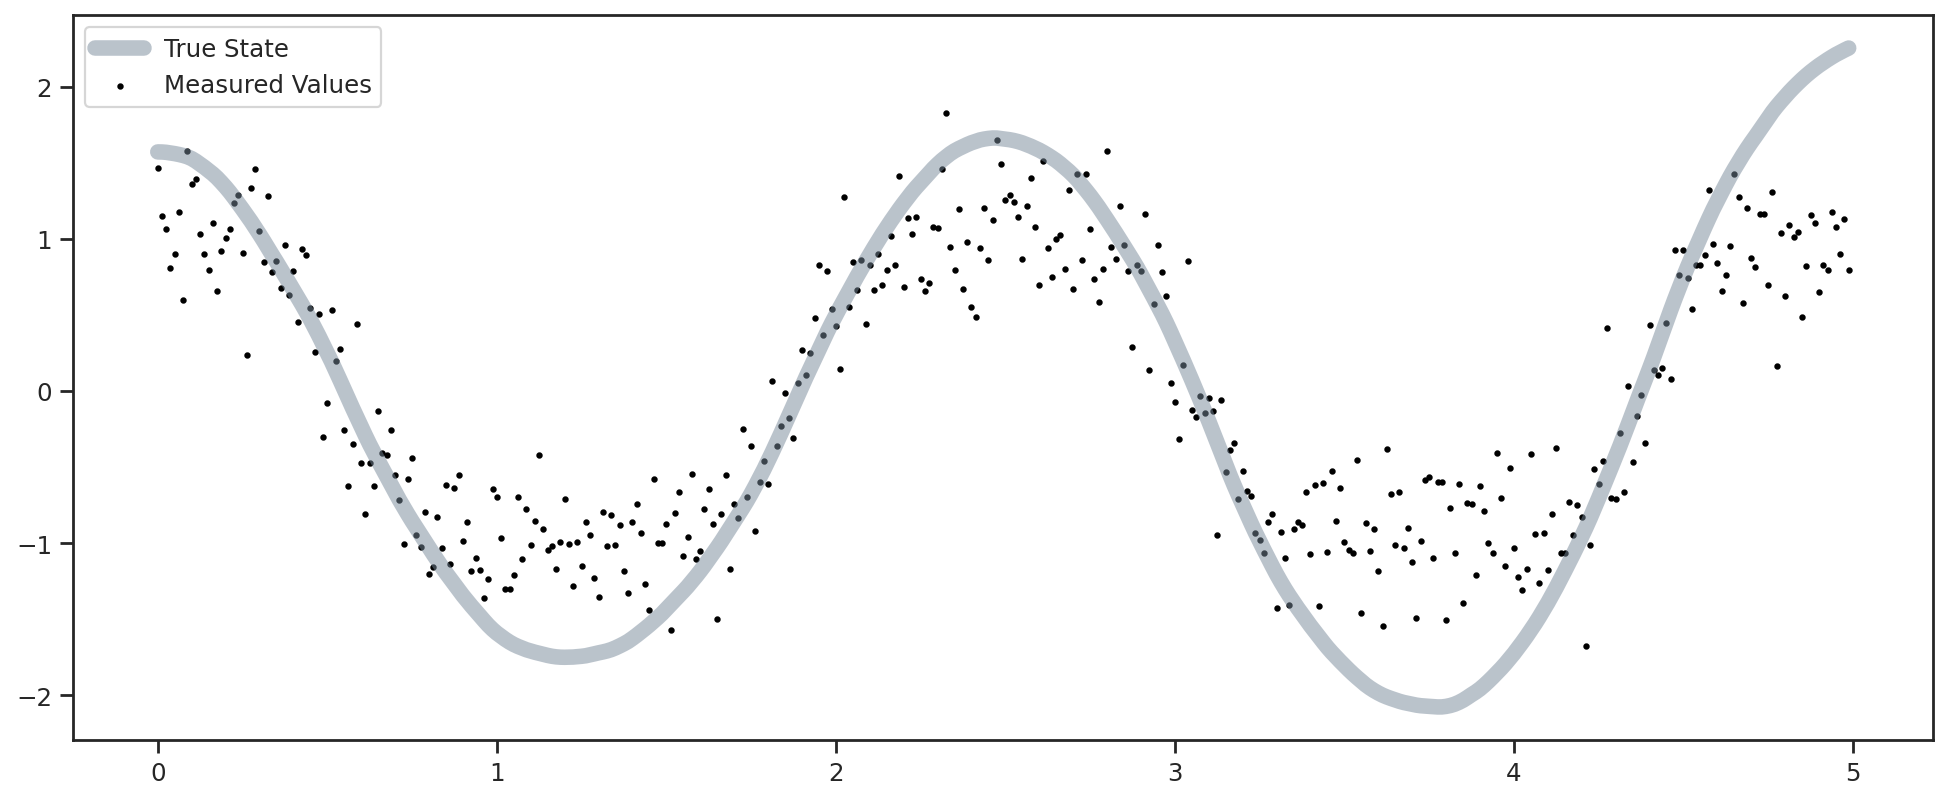

In [17]:
X = np.arange(0, 5, dt).reshape(-1, 1)

Q_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(Q)).sample(X.shape[0])

R_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(R)).sample(X.shape[0])

state_ = initial_state; state_I = initial_state
state = []; obs = []

for i in range(X.shape[0]):
  state_ = f(state_) + Q_samples[i, :, tf.newaxis]
  obs_ = h(state_) + R_samples[i, :, tf.newaxis]
  state.append(state_)
  obs.append(obs_)
  

state = np.array(state).reshape(-1, 2)
obs = np.array(obs).reshape(-1, 2)
print((obs).shape)

plt.figure(figsize=(15, 6))
plt.plot(X, state[:,0], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.scatter(X, obs[:, 0], color="black", s=3.5, alpha=1.0, label="Measured Values")
plt.legend(); plt.show()

100%|█████████▉| 399/400 [01:55<00:00,  3.45it/s]


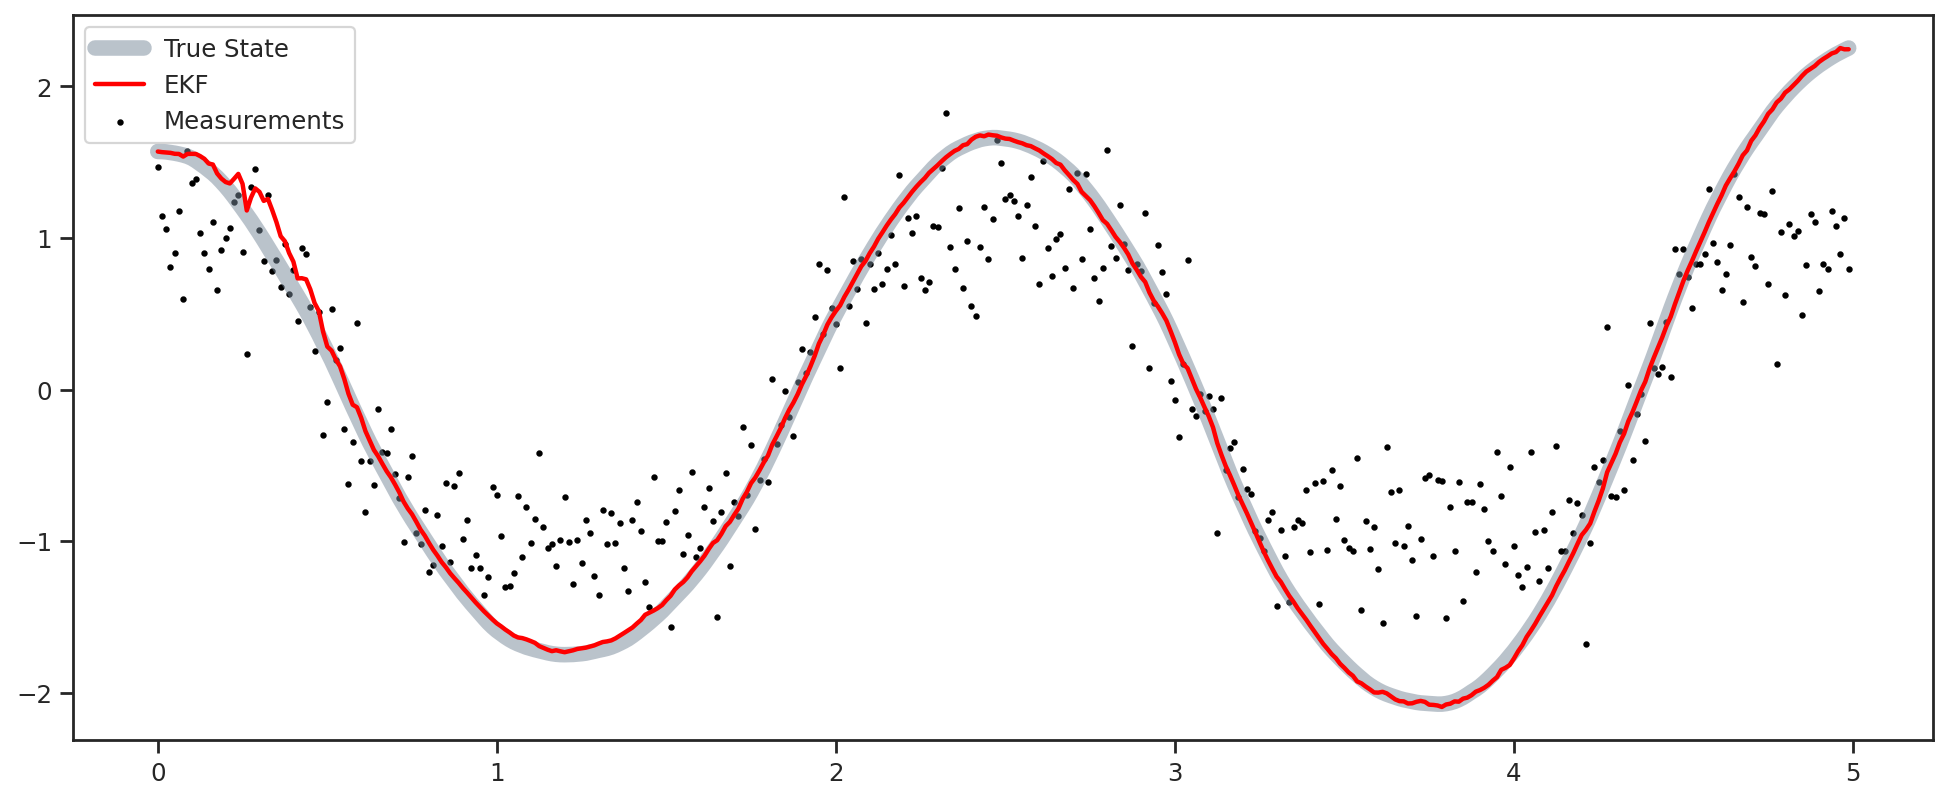

In [18]:
Σ_0 = tf.eye(2)*0.1
µ, Σ = ExtendedKalmanFilter(f, Q, h, R, obs, initial_state, Σ_0, 1)
µ = np.array(µ)

plt.figure(figsize=(15, 6))
plt.plot(X, state[:,0], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.scatter(X, obs[:, 0], color="black", s=3.5, alpha=1.0, label="Measurements")
plt.plot(X, np.array(µ)[:,0], color="red", linewidth=2.0, alpha=1, label="EKF")
plt.legend(); plt.show()

## EKF on Tracking a Spiraling Object
### [Reference](https://colab.research.google.com/github/probml/dynamax/blob/main/docs/notebooks/nonlinear_gaussian_ssm/ekf_ukf_spiral.ipynb)

The state equations are

\begin{align*}
  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}
&=
  \begin{pmatrix} z_{1,t-1} + 0.4\cdot \sin(z_{2,t-1} )  \\
    z_{2,t-1} + 0.4\cdot \cos(z_{1,t-1} )
     \end{pmatrix}
+q_{t} \\ \\
  y_t
&=  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}\\ \\
q_t &\sim N(0,Q) \\
r_t &\sim N(0,R)\\ \\
Q &= c\cdot\mathbf I \\
R &= d\cdot\mathbf I
\end{align*}
for some constants $c, \ d$.

In [19]:
@tf.function
def f(x):
  return x + 0.4 * tf.stack([tf.sin(x[1]), 
                             tf.cos(x[0])])

@tf.function
def h(x):
  return x

Q = tf.eye(2)*0.001
R = tf.eye(2)*0.05

initial_state = tf.constant([1.5, 0])[:, tf.newaxis]

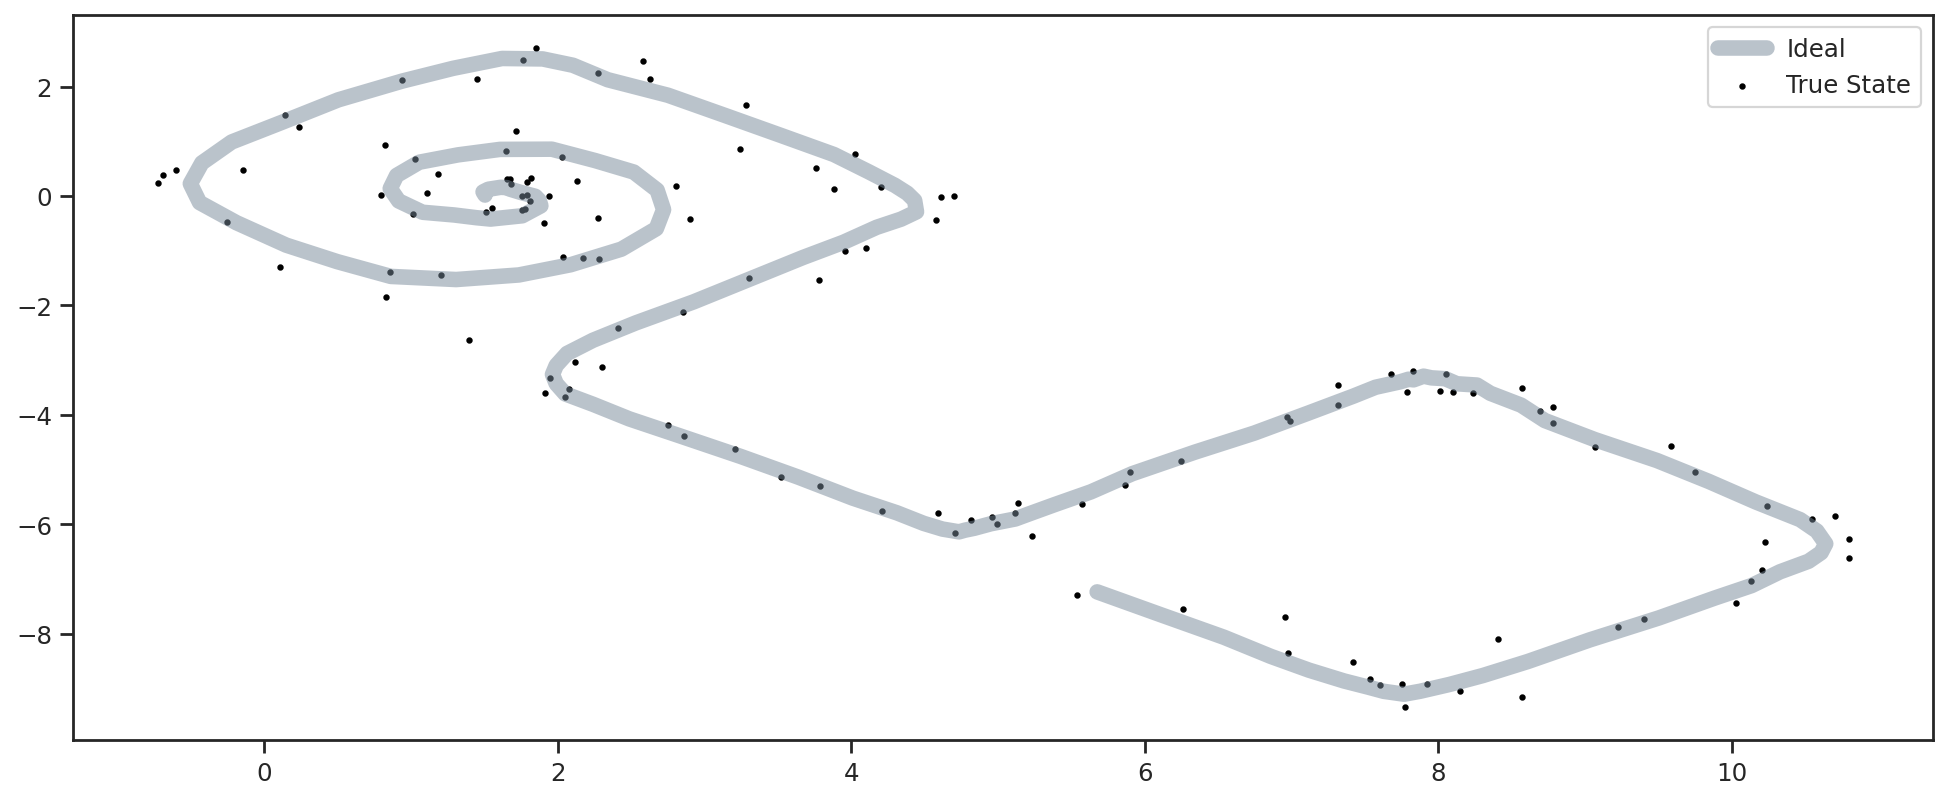

In [23]:
steps = 130

Q_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(Q)).sample(steps)

R_samples = tfd.MultivariateNormalTriL(
    loc=0,
    scale_tril=tf.linalg.cholesky(R)).sample(steps)

state_ = initial_state
state = []; obs = []

for i in range(steps):
  state_ = f(state_) + Q_samples[i, :, tf.newaxis]
  obs_ = h(state_) + R_samples[i, :, tf.newaxis]
  state.append(state_)
  obs.append(obs_)

state = np.array(state).reshape(-1, 2)
obs = np.array(obs).reshape(-1, 2)

plt.figure(figsize=(15, 6))
plt.scatter(obs[:,0], obs[:,1], color="black", s=3.5, alpha=1.0, label="True State")
plt.plot(state[:,0], state[:,1], color="lightslategray", linewidth=7.0, alpha=0.5, label="Ideal")
plt.legend(); plt.show()

 99%|█████████▉| 129/130 [00:31<00:00,  4.08it/s]


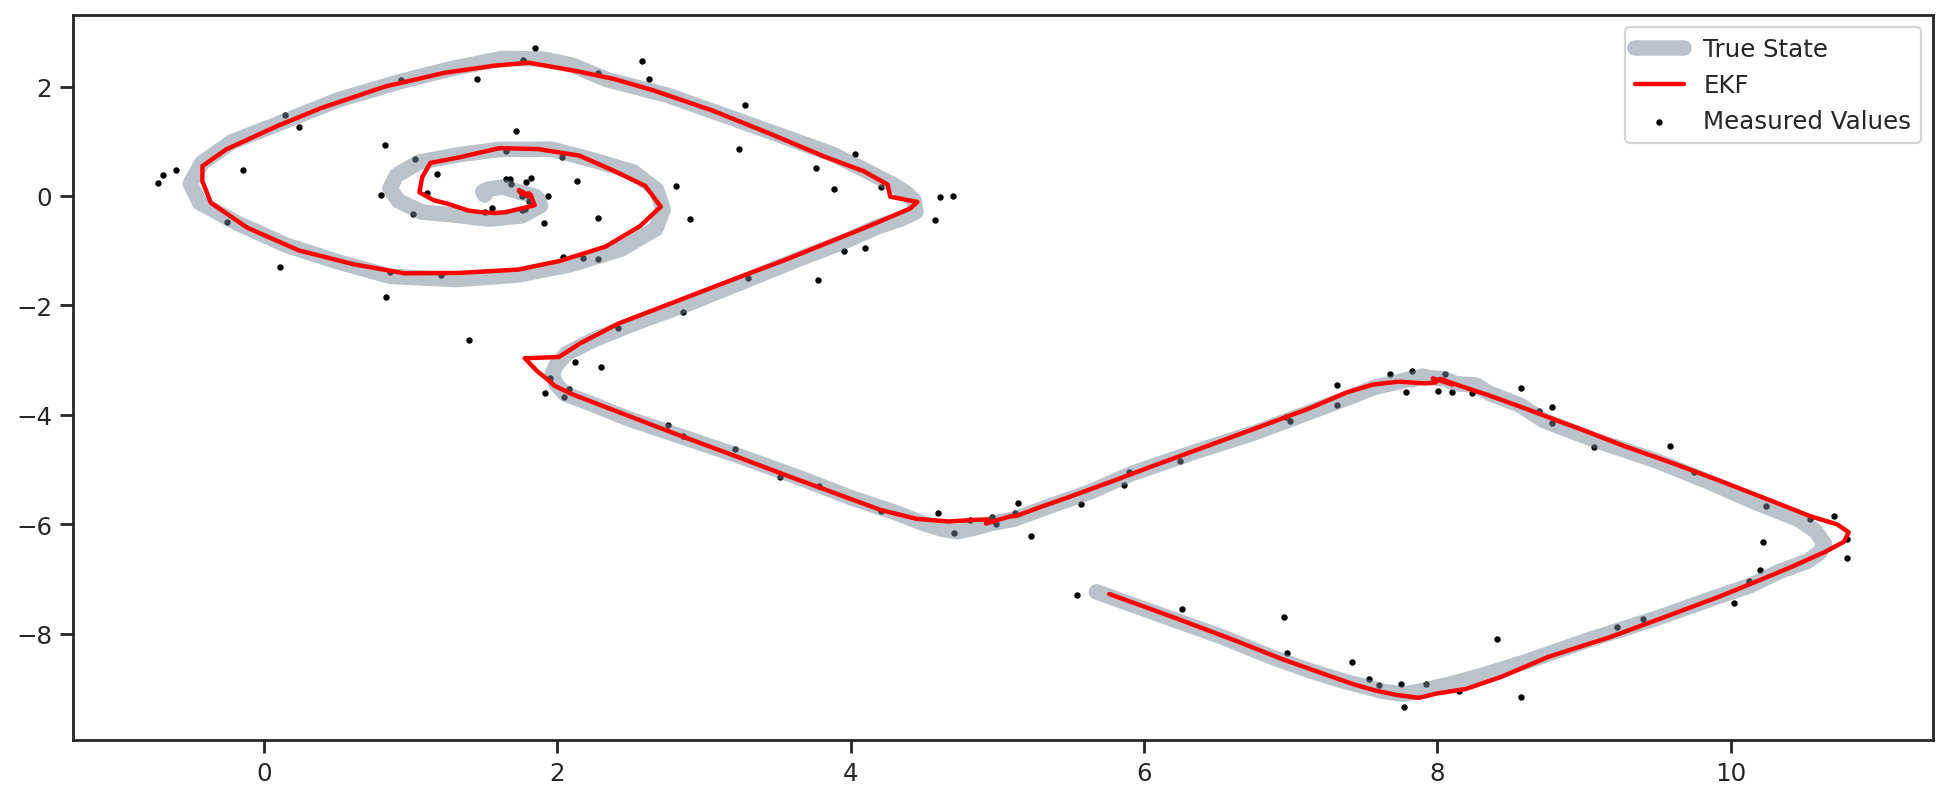

In [24]:
Σ_0 = tf.eye(2)*0.1
µ, Σ = ExtendedKalmanFilter(f, Q, h, R, obs, initial_state, Σ_0, 1)
µ = np.array(µ)

plt.figure(figsize=(15, 6))
plt.plot(state[:,0], state[:,1], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.scatter(obs[:,0], obs[:,1], color="black", s=3.5, alpha=1.0, label="Measured Values")
plt.plot(µ[:,0], µ[:,1], color="red", linewidth=2.0, alpha=1, label="EKF")
plt.legend(); plt.show()

 99%|█████████▉| 129/130 [02:04<00:00,  1.04it/s]


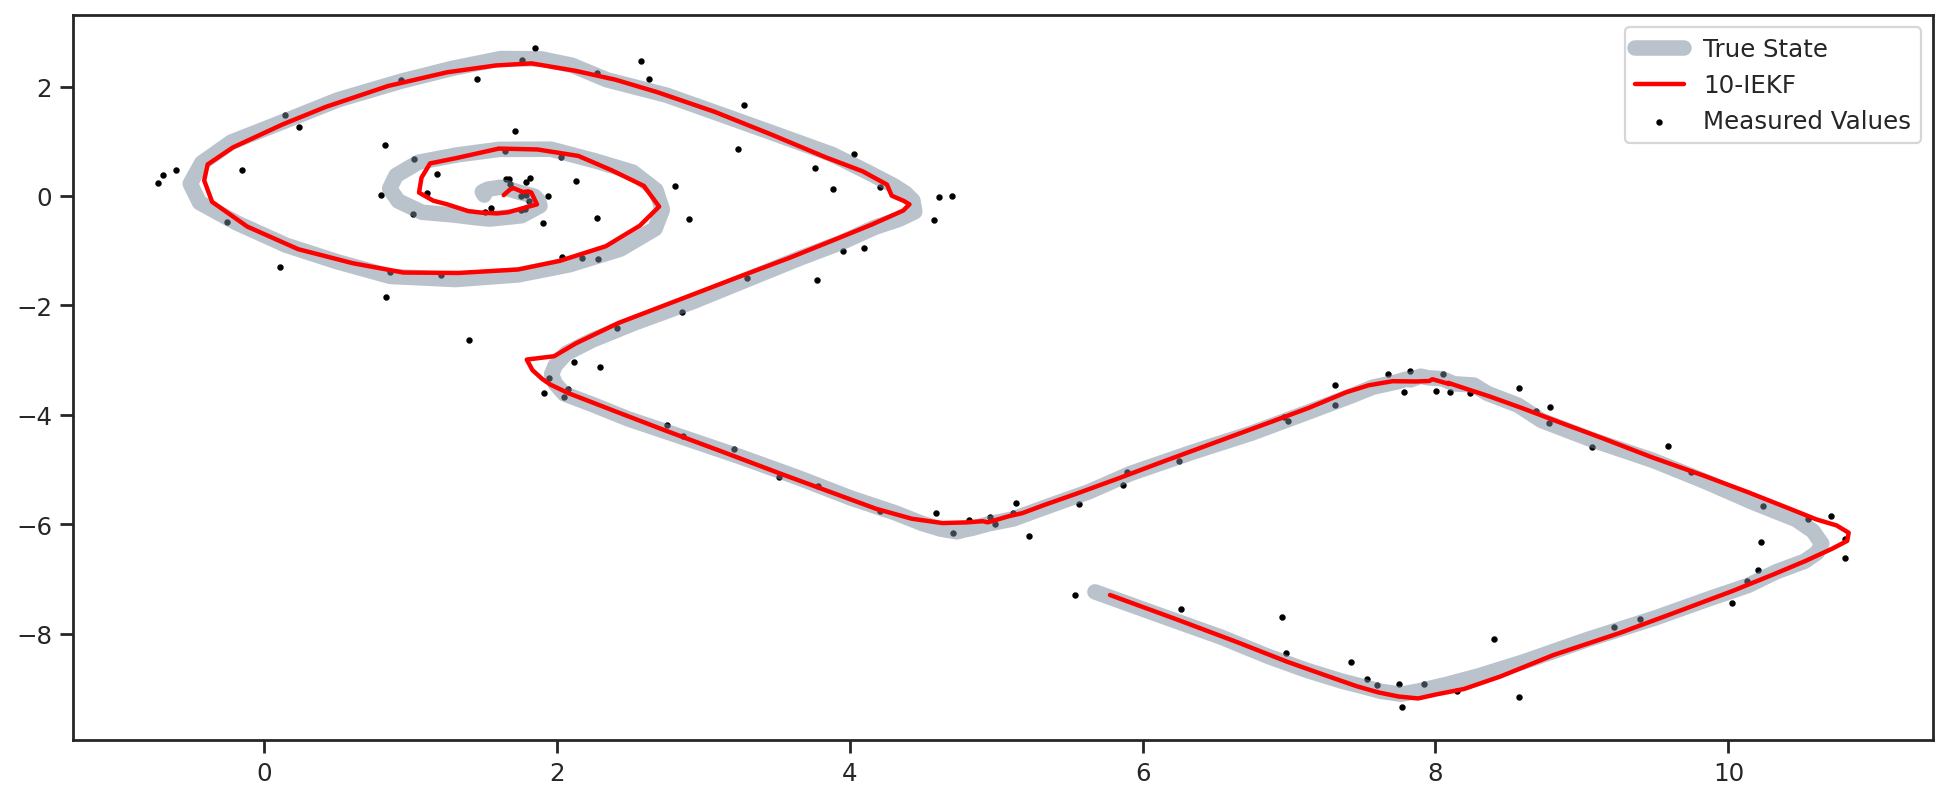

In [25]:
J = 10
µ, Σ = ExtendedKalmanFilter(f, Q, h, R, obs, initial_state, Σ_0, J)
µ = np.array(µ)

plt.figure(figsize=(15, 6))
plt.plot(state[:,0], state[:,1], color="lightslategray", linewidth=7.0, alpha=0.5, label="True State")
plt.scatter(obs[:,0], obs[:,1], color="black", s=3.5, alpha=1.0, label="Measured Values")
plt.plot(µ[:,0], µ[:,1], color="red", linewidth=2.0, alpha=1, label= str(J) + "-IEKF")
plt.legend(); plt.show()